In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind, LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


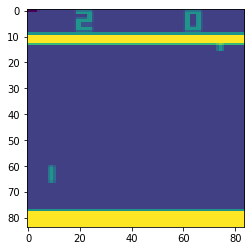

In [2]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [3]:
class NoisyFactorizedLinear(nn.Linear):
    """
    NoisyNet layer with factorized gaussian noise
    N.B. nn.Linear already initializes weight and bias to
    """
    def __init__(self, in_features, out_features, sigma_zero=0.4, bias=True):
        super(NoisyFactorizedLinear, self).__init__(in_features, out_features, bias=bias)
        sigma_init = sigma_zero / math.sqrt(in_features)
        self.sigma_weight = nn.Parameter(torch.Tensor(out_features, in_features).fill_(sigma_init))
        self.register_buffer("epsilon_input", torch.zeros(1, in_features))
        self.register_buffer("epsilon_output", torch.zeros(out_features, 1))
        if bias:
            self.sigma_bias = nn.Parameter(torch.Tensor(out_features).fill_(sigma_init))

    def forward(self, input):
        bias = self.bias
        func = lambda x: torch.sign(x) * torch.sqrt(torch.abs(x))

        with torch.no_grad():
            torch.randn(self.epsilon_input.size(), out=self.epsilon_input)
            torch.randn(self.epsilon_output.size(), out=self.epsilon_output)
            eps_in = func(self.epsilon_input)
            eps_out = func(self.epsilon_output)
            noise_v = torch.mul(eps_in, eps_out).detach()
        if bias is not None:
            bias = bias + self.sigma_bias * eps_out.t()
        return F.linear(input, self.weight + self.sigma_weight * noise_v, bias)

class Noisy_DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(Noisy_DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = NoisyFactorizedLinear(7 * 7 * 64, 512)
        self.fc5 = NoisyFactorizedLinear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)
    

In [4]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [5]:
class Noisy_DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = Noisy_DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = Noisy_DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())

        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state):
        """
        action follows greedy policy (with intrinsic noise generated from NoisyNet)
        """
        q_values = self.value(state).cpu().detach().numpy()
        aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())
        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [6]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
frames = 1000000
USE_CUDA = True
learning_rate = 1e-4
max_buff = 100000
update_tar_interval = 5000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
update_current_step =4 # update current model every 4 steps
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = Noisy_DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate, memory_size = max_buff)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "6_Noisy_DQN_new2", comment= "good_makeatari")


for i in range(frames):
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor)
    
    next_frame, reward, is_done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, is_done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        if i % update_current_step == 0:
            loss = agent.learn_from_experience(batch_size)
            losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if is_done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

F:\softwares\ANACONDA\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\softwares\ANACONDA\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, episode:    0
frames:  1000, reward: -21.000000, loss: 0.000000, episode:    1
frames:  2000, reward: -21.000000, loss: 0.000000, episode:    2
frames:  3000, reward: -21.000000, loss: 0.000000, episode:    3
frames:  4000, reward: -21.000000, loss: 0.000000, episode:    5
frames:  5000, reward: -21.000000, loss: 0.000000, episode:    6
frames:  6000, reward: -21.000000, loss: 0.000000, episode:    7
frames:  7000, reward: -21.000000, loss: 0.000000, episode:    9
frames:  8000, reward: -21.000000, loss: 0.000000, episode:   10
frames:  9000, reward: -21.000000, loss: 0.000000, episode:   11
frames: 10000, reward: -21.000000, loss: 0.032251, episode:   13
frames: 11000, reward: -20.900000, loss: 0.000695, episode:   14
frames: 12000, reward: -20.700000, loss: 0.015139, episode:   15
frames: 13000, reward: -20.700000, loss: 0.000849, episode:   16
frames: 14000, reward: -20.600000, loss: 0.000401, episode:   17
frames: 15000, reward: -20.600

frames: 126000, reward: -20.300000, loss: 0.000283, episode:  147
frames: 127000, reward: -20.500000, loss: 0.000265, episode:  149
frames: 128000, reward: -20.400000, loss: 0.029867, episode:  150
frames: 129000, reward: -20.400000, loss: 0.000388, episode:  151
frames: 130000, reward: -20.400000, loss: 0.026610, episode:  152
frames: 131000, reward: -20.400000, loss: 0.014898, episode:  153
frames: 132000, reward: -20.500000, loss: 0.000128, episode:  154
frames: 133000, reward: -20.400000, loss: 0.000030, episode:  156
frames: 134000, reward: -20.300000, loss: 0.014891, episode:  157
frames: 135000, reward: -20.300000, loss: 0.015979, episode:  158
frames: 136000, reward: -20.300000, loss: 0.015023, episode:  159
frames: 137000, reward: -20.400000, loss: 0.000842, episode:  160
frames: 138000, reward: -20.300000, loss: 0.012260, episode:  161
frames: 139000, reward: -20.100000, loss: 0.015457, episode:  162
frames: 140000, reward: -20.100000, loss: 0.015600, episode:  164
frames: 14

frames: 251000, reward: -20.400000, loss: 0.043163, episode:  290
frames: 252000, reward: -20.500000, loss: 0.028646, episode:  291
frames: 253000, reward: -20.500000, loss: 0.000105, episode:  293
frames: 254000, reward: -20.600000, loss: 0.015493, episode:  294
frames: 255000, reward: -20.700000, loss: 0.000646, episode:  295
frames: 256000, reward: -20.800000, loss: 0.014848, episode:  296
frames: 257000, reward: -20.800000, loss: 0.015726, episode:  297
frames: 258000, reward: -20.800000, loss: 0.000124, episode:  298
frames: 259000, reward: -20.800000, loss: 0.000143, episode:  299
frames: 260000, reward: -20.800000, loss: 0.000201, episode:  301
frames: 261000, reward: -20.800000, loss: 0.015506, episode:  302
frames: 262000, reward: -20.800000, loss: 0.014863, episode:  303
frames: 263000, reward: -20.800000, loss: 0.000205, episode:  304
frames: 264000, reward: -20.800000, loss: 0.014449, episode:  305
frames: 265000, reward: -20.800000, loss: 0.000489, episode:  306
frames: 26

frames: 376000, reward: -20.600000, loss: 0.004533, episode:  436
frames: 377000, reward: -20.600000, loss: 0.004012, episode:  437
frames: 378000, reward: -20.600000, loss: 0.024028, episode:  438
frames: 379000, reward: -20.600000, loss: 0.010660, episode:  439
frames: 380000, reward: -20.500000, loss: 0.002233, episode:  440
frames: 381000, reward: -20.500000, loss: 0.005407, episode:  441
frames: 382000, reward: -20.500000, loss: 0.004034, episode:  443
frames: 383000, reward: -20.600000, loss: 0.001561, episode:  444
frames: 384000, reward: -20.500000, loss: 0.011417, episode:  445
frames: 385000, reward: -20.500000, loss: 0.005690, episode:  446
frames: 386000, reward: -20.500000, loss: 0.007146, episode:  447
frames: 387000, reward: -20.600000, loss: 0.023203, episode:  448
frames: 388000, reward: -20.600000, loss: 0.004677, episode:  449
frames: 389000, reward: -20.600000, loss: 0.006225, episode:  451
frames: 390000, reward: -20.600000, loss: 0.005303, episode:  452
frames: 39

frames: 501000, reward: -20.700000, loss: 0.003184, episode:  581
frames: 502000, reward: -20.700000, loss: 0.002818, episode:  582
frames: 503000, reward: -20.700000, loss: 0.002383, episode:  583
frames: 504000, reward: -20.800000, loss: 0.000984, episode:  585
frames: 505000, reward: -20.700000, loss: 0.010444, episode:  586
frames: 506000, reward: -20.700000, loss: 0.001482, episode:  587
frames: 507000, reward: -20.700000, loss: 0.004136, episode:  588
frames: 508000, reward: -20.900000, loss: 0.002771, episode:  590
frames: 509000, reward: -20.900000, loss: 0.006435, episode:  591
frames: 510000, reward: -20.900000, loss: 0.001310, episode:  592
frames: 511000, reward: -20.900000, loss: 0.001986, episode:  593
frames: 512000, reward: -20.800000, loss: 0.002334, episode:  595
frames: 513000, reward: -20.800000, loss: 0.001248, episode:  596
frames: 514000, reward: -20.800000, loss: 0.001945, episode:  597
frames: 515000, reward: -20.800000, loss: 0.004196, episode:  598
frames: 51

frames: 626000, reward: -19.900000, loss: 0.001905, episode:  718
frames: 627000, reward: -20.000000, loss: 0.000582, episode:  719
frames: 628000, reward: -20.000000, loss: 0.006408, episode:  720
frames: 629000, reward: -20.000000, loss: 0.002400, episode:  720
frames: 630000, reward: -20.300000, loss: 0.002794, episode:  722
frames: 631000, reward: -20.300000, loss: 0.000614, episode:  723
frames: 632000, reward: -20.500000, loss: 0.017746, episode:  724
frames: 633000, reward: -20.400000, loss: 0.003316, episode:  725
frames: 634000, reward: -20.200000, loss: 0.002168, episode:  726
frames: 635000, reward: -20.100000, loss: 0.002243, episode:  727
frames: 636000, reward: -20.500000, loss: 0.002150, episode:  728
frames: 637000, reward: -20.500000, loss: 0.001932, episode:  729
frames: 638000, reward: -20.500000, loss: 0.002540, episode:  730
frames: 639000, reward: -20.600000, loss: 0.004294, episode:  731
frames: 640000, reward: -20.600000, loss: 0.002248, episode:  732
frames: 64

frames: 751000, reward: -20.700000, loss: 0.002373, episode:  834
frames: 752000, reward: -20.600000, loss: 0.002154, episode:  835
frames: 753000, reward: -20.600000, loss: 0.001953, episode:  836
frames: 754000, reward: -20.600000, loss: 0.001277, episode:  837
frames: 755000, reward: -20.600000, loss: 0.001665, episode:  838
frames: 756000, reward: -20.600000, loss: 0.001223, episode:  839
frames: 757000, reward: -20.600000, loss: 0.002084, episode:  840
frames: 758000, reward: -20.500000, loss: 0.009286, episode:  841
frames: 759000, reward: -20.200000, loss: 0.017326, episode:  842
frames: 760000, reward: -19.700000, loss: 0.001317, episode:  843
frames: 761000, reward: -19.700000, loss: 0.001090, episode:  843
frames: 762000, reward: -19.700000, loss: 0.001068, episode:  844
frames: 763000, reward: -19.700000, loss: 0.004965, episode:  845
frames: 764000, reward: -19.400000, loss: 0.002267, episode:  846
frames: 765000, reward: -19.600000, loss: 0.005103, episode:  848
frames: 76

frames: 876000, reward: -19.500000, loss: 0.001369, episode:  952
frames: 877000, reward: -19.800000, loss: 0.002290, episode:  953
frames: 878000, reward: -19.600000, loss: 0.002291, episode:  954
frames: 879000, reward: -19.300000, loss: 0.001196, episode:  955
frames: 880000, reward: -19.300000, loss: 0.032091, episode:  955
frames: 881000, reward: -19.000000, loss: 0.002044, episode:  957
frames: 882000, reward: -19.200000, loss: 0.005322, episode:  958
frames: 883000, reward: -19.400000, loss: 0.002080, episode:  959
frames: 884000, reward: -19.000000, loss: 0.003861, episode:  960
frames: 885000, reward: -19.100000, loss: 0.004491, episode:  961
frames: 886000, reward: -19.200000, loss: 0.002191, episode:  962
frames: 887000, reward: -19.500000, loss: 0.012612, episode:  963
frames: 888000, reward: -19.600000, loss: 0.002157, episode:  964
frames: 889000, reward: -19.800000, loss: 0.002484, episode:  965
frames: 890000, reward: -19.600000, loss: 0.001174, episode:  966
frames: 89

In [ ]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)